**Задание 1: Векторизация текста с использованием Мешка слов (BoW) и TF-IDF**

1. Создайте корпус из минимум 10 текстовых документов (можно взять новостные статьи, отзывы на товары, статьи по одной тематике).
2. Реализуйте предобработку текста, включающую:
* Приведение к нижнему регистру
* Токенизацию
* Удаление стоп-слов и пунктуации
* Лемматизацию/стемминг
3. Реализуйте модель Мешка слов (BoW) с использованием CountVectorizer из scikit-learn.
4. Реализуйте модель TF-IDF с использованием TfidfVectorizer из scikit-learn.
5. Найдите 10 самых значимых терминов для каждого документа по обоим подходам и сравните результаты.
6. Визуализируйте сходство документов с помощью метрики косинусного расстояния для обоих подходов.
7. Прокомментируйте разницу в результатах между BoW и TF-IDF

In [1]:
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
stemmer = SnowballStemmer("russian")


import spacy

!pip install gensim
!python -m spacy download en_core_web_sm
!python -m spacy download ru_core_news_sm

nlp_ru = spacy.load("ru_core_news_sm")
nlp_en = spacy.load("en_core_web_sm")

lemmatizer_ru = nlp_ru.get_pipe("lemmatizer")
lemmatizer_en = nlp_en.get_pipe("lemmatizer")

import sklearn
from sklearn.feature_extraction.text import CountVectorizer  # Для создания Bag of Words
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 36.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 56.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 35.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do

In [76]:
raw_documents = [
    """Сложно сказать, о чём книга – остров, пропавшая девушка, размышления главного героя… Легче сказать – о послевкусии. Оно – приятное, тёплое, в меру ошеломляющее и в меру восхищающее. Это из тех книг, сам процесс чтения которых доставляет удовольствие. Немного похоже на сон – пересказать сложно, ощущение остаётся) И ощущение это – очень приятное и вызывающее улыбку.""",
    """Блестящий автор, создавший несколько шедевров, и на мой вкус – это самая блестящая его книга. Тонкая и искренняя, полная недосказанности и тайны. Немного трагичная, но оставляющая большой ломоть надежды. Метафизика непростых, глубоких отношений между героями струится со всех страниц. Книга о падении в одиночество и о том, что не дает нам в него упасть. Книга о людях, книга о жизни. О тонких чувствах тех, кому с рождения дано чувствовать тонко и о радости, которую испытывают они, когда кому-то удается с ними эти чувства разделить. Если вы еще не читали – советую.""",
    """В общем и целом, могу сказать, что книга заслуживает вашего внимания. Сюжет сочетает в себе разные жанры, стили и приёмы. Мистика пронизывает весь роман, но оставляет след современности. Единственный явный недочёт: не раскрыли толком героев, дав всего 270 страниц. Оценка: 7,8/10. Что же за мистика? Я придерживаюсь своих канонов, поэтому спойлерить будущим чтецам не буду, но хочу предупредить, что в книге есть моменты, способные вызвать приятные мурашки по вашему телу. Без шуток, Мураками сделал необычно, обыграл все под метафорами, подкрепил аллегорией. Любителям чего-то потустороннего, завлекающего, следует прочесть таковой труд.""",
    """Книга о том, что некоторые люди даны нам лишь на короткий промежуток времени, чтоб стать нашими попутчиками в нашем же одиночестве. Три главных персонажа, и у них разные причины почему они выбрали того или иного человека в качестве спутника, в качестве того, кто сможет затянуть пустоту в душе. У кого-то все кроется в отсутствии матери с раннего детства, у кого-то в нехватке интереса со стороны семьи, у кого-то в неудачном опыте с мужчинами. Книга рассказывает о прелестях наличия близкого человека рядом, перед кем можно открыть душу и узнать себя с новой стороны; о том, как переживается потеря того самого человека, как ощущается потеря части себя (возможно, самой важной). Книга о любви, которая возникает из легких душевных многочасовых разговоров, где искренний интерес друг к другу стоит во главе, интерес к мнению человека, его прошлому, его принципам, его вкусам и всему, что его составляет.""",
    """На первый взгляд, не видишь в данном произведении ничего серьёзного. Обычная жизнь, немного необычные отношения трех людей, иногда встречаются сложные для восприятия моменты…Вся глубина начинается где-то с середины. Она настолько обволакивает, настолько потрясает, кажется, что и сам какую-то часть себя потерял и после прочтения уже никогда не будешь прежним. Есть над чем подумать…Книга интересная, глубокая, необычная и о самом лучшем, что может быть в жизни – о любви и искренней дружбе.""",
    """В этой книге затрагивается, столь часто используемая Мураками, тема другого мира, а также проблемы одиночества, и неразделенной любви. Для меня книга оказалась немного сложной к пониманию с точки зрения сюжета и причинно-следственных связей …много что приходится додумывать, точных ответов почему так нет. Я сделала для себя вывод, что автор описывает что герои сталкиваются в жизни с потрясениями, которые лишают их части себя… остаются только пустые оболочки…поднимается тема одиночества, все связи не вечны. Возможно люди сравниваются со спутниками, которые бороздят космос в одиночку..вообще после прочтения этой книге хочется больше ценить своих близких людей, вот такое у меня осталось впечатление.""",
    """В романе мало действий, зато много рефлексии, музыки, еды, сексуальности (но та обозначена легкими штрихами). Это мой второй роман у автора, и, как в «Норвежском лесу», тут многого, чего ждешь от захватывающей истории, нет, зато есть атмосфера. Та самая, за которую я могу простить практически все. Это как смотреть сквозь запотевшее стекло на того, кого считаешь самым красивым. Для меня самой красивой в этой истории стала Сумирэ – влюбленная, нежная, в разных носках, печатающая свои тексты и пытающаяся разобраться в себе. В конце – наверное, успешно… Мы этого уже не узнаем. Финал романа неопределенный, не бьющий наотмашь, но яркий, как лунный свет, который можно спутать с лучом прожектора.""",
    """это была моя первая книга от харуки мураками, на которую я строила ОГРОМНЫЕ ожидания. соглашусь с мнением о том, что она по большей части берет не сюжетом, а именно своей атмосферой. но иногда многочисленные описания становились для меня ужасной мукой: тебя просто будто захлестывает волной бесконечных деталей различных подробностей, которые большой силы в основном и не несут. первая половина просто кишит захватывающей атмосферой, она не наполнена яркими событиями — она берёт эмоциями. вторая же наоборот имеет много неожиданных поворотов, но добавление в историю некой мистики и огромного количества непоняток совсем сбили мой положительный настрой. в общем книга очень на любителя.""",
    """японская литература, лично для меня, хороша именно атмосферой, но сюжетом я в основном не проникаюсь - может, из-за различий менталитетов, я не знаю. если честно, то показалось, что все персонажи - какие-то моральные уроды, и, увы, автор будто не смог интересно изобразить их порой не слишком приятные черты характеров, оттого сопереживать им давалось с натяжкой. концовку, признаться, вообще не поняла. люблю, когда авторы дают некую пищу для размышлений, но в данном случае был лишь один вопрос/мысль с голове: «какого черта?». действительно, я думаю, книга на любителя.""",
    """Я сразу знала, что это книга выстрелит прямо в яблочко. После того, как я её дочитала, мне потребовалось время, чтобы снова установить связь с реальностью. Казалось, что что-то во мне осталось там, в книге, вместе с Сумирэ и Мюу, вместе с главным героем. Где-то на той стороне. Книга была для меня более понятна, чем 'Кафка на пляже', до определённого момента вообще было ощущение, что всё так и останется обычной повседневностью. Но Мураками был бы не Мураками, если бы в один момент не добавил некой мистики. Но в этот раз это было менее безумно. Мне нравится стиль, которым Мураками описывает жизнь. Меня это успокаивает. Нашла нечто близкое мне в каждом герое, привязалась к ним, словно отдала им кусочки себя. Для меня 'Мой любимый sputnik' оказался чем-то до безумия личным, тем, что хочется спрятать ото всех в дальнем углу выдвижного ящика стола. Эта книга о людях и одиночестве, о дружбе и любви, о музыке и письме, об исчезновении и потере. Ну и конечно, это книга о спутниках."""
]

# Предобработка
def preprocess_texts(texts):
    docs_lemmas = []

    for text in texts:
        text = text.lower()
        tokens = word_tokenize(text)
        tokens = [token for token in tokens if token not in string.punctuation]
        stop_words = set(stopwords.words('russian'))
        tokens = [token for token in tokens if token not in stop_words]
        doc = nlp_ru(" ".join(tokens))
        lemmas = [token.lemma_ for token in doc if token.lemma_ != "" and not token.is_punct and not token.is_space]
        docs_lemmas.append(lemmas)

    return docs_lemmas

documents = preprocess_texts(raw_documents)
for i, doc in enumerate(documents, 1):
    print(f"Документ {i}: {doc}")



Документ 1: ['сложный', 'сказать', 'чём', 'книга', 'остров', 'пропасть', 'девушка', 'размышление', 'главный', 'герой', 'лёгкий', 'сказать', 'послевкусии', 'оно', 'приятный', 'тёплый', 'мера', 'ошеломлять', 'мера', 'восхищать', 'это', 'тот', 'книга', 'процесс', 'чтение', 'которых', 'доставлять', 'удовольствие', 'немного', 'похожий', 'сон', 'пересказать', 'сложный', 'ощущение', 'оставаться', 'ощущение', 'это', 'очень', 'приятный', 'вызывать', 'улыбка']
Документ 2: ['блестеть', 'автор', 'создать', 'несколько', 'шедевр', 'вкус', 'это', 'самая', 'блестящий', 'книга', 'тонкий', 'искренний', 'полный', 'недосказанности', 'тайна', 'немного', 'трагичный', 'оставлять', 'большой', 'ломоть', 'надежда', 'метафизик', 'непростой', 'глубокий', 'отношение', 'герой', 'струиться', 'страница', 'книга', 'падении', 'одиночество', 'давать', 'нам', 'упасть', 'книга', 'человек', 'книга', 'жизнь', 'тонкий', 'чувство', 'тот', 'кто', 'рождение', 'дать', 'чувствовать', 'тонко', 'радость', 'которую', 'испытывать', '

In [77]:
# Модель Мешка слов (BoW) с использованием CountVectorizer из scikit-learn
documents = [' '.join(doc) for doc in documents]
count_vectorizer = CountVectorizer()
bow_matrix = count_vectorizer.fit_transform(documents)
feature_names = count_vectorizer.get_feature_names_out()
bow_df = pd.DataFrame(
    bow_matrix.toarray(),
    columns=feature_names,
    index=[f'Документ {i+1}' for i in range(len(documents))]
)

# Вывод матрицы Bag of Words
print("Матрица Bag of Words:")
print(bow_df)


Матрица Bag of Words:
             10  270  sputnik  автор  аллегория  атмосфера  атмосферой  \
Документ 1    0    0        0      0          0          0           0   
Документ 2    0    0        0      1          0          0           0   
Документ 3    1    1        0      0          1          0           0   
Документ 4    0    0        0      0          0          0           0   
Документ 5    0    0        0      0          0          0           0   
Документ 6    0    0        0      1          0          0           0   
Документ 7    0    0        0      1          0          1           0   
Документ 8    0    0        0      0          0          2           0   
Документ 9    0    0        0      2          0          0           1   
Документ 10   0    0        1      0          0          0           0   

             безумия  безумно  берёт  ...  штрих  шутка  эмоция  это  этот  \
Документ 1         0        0      0  ...      0      0       0    2     0   
Докумен

In [78]:
#Модель TF-IDF с использованием TfidfVectorizer из scikit-learn
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(documents)

tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(),
    columns=tfidf_vectorizer.get_feature_names_out(),
    index=[f'Документ {i+1}' for i in range(len(documents))]
)

# Вывод матрицы TF-IDF
print("Матрица TF-IDF:")
print(tfidf_df)

Матрица TF-IDF:
                   10       270   sputnik     автор  аллегория  атмосфера  \
Документ 1   0.000000  0.000000  0.000000  0.000000   0.000000   0.000000   
Документ 2   0.000000  0.000000  0.000000  0.092764   0.000000   0.000000   
Документ 3   0.126389  0.126389  0.000000  0.000000   0.126389   0.000000   
Документ 4   0.000000  0.000000  0.000000  0.000000   0.000000   0.000000   
Документ 5   0.000000  0.000000  0.000000  0.000000   0.000000   0.000000   
Документ 6   0.000000  0.000000  0.000000  0.083800   0.000000   0.000000   
Документ 7   0.000000  0.000000  0.000000  0.078241   0.000000   0.100589   
Документ 8   0.000000  0.000000  0.000000  0.000000   0.000000   0.215188   
Документ 9   0.000000  0.000000  0.000000  0.184239   0.000000   0.000000   
Документ 10  0.000000  0.000000  0.103886  0.000000   0.000000   0.000000   

             атмосферой   безумия   безумно     берёт  ...     штрих  \
Документ 1     0.000000  0.000000  0.000000  0.000000  ...  0.00

In [79]:
#Найдите 10 самых значимых терминов для каждого документа по обоим подходам и сравните результаты.


# Суммируем значения по всем документам для BOW
# Для BOW просто суммируем частоты слов по всем документам
bow_sum = np.sum(bow_matrix.toarray(), axis=0)

# Создаем словарь слово -> суммарная частота
word_bow_dict = dict(zip(feature_names, bow_sum))

# Находим топ-3 слова по BOW (самые частотные в коллекции)
top_bow_words = sorted(word_bow_dict.items(), key=lambda x: x[1], reverse=True)[:10]

print("=== Топ-10 слов по всей коллекции ===\n")
print("Топ-10 слов по BOW (самые частые в коллекции):")
for word, count in top_bow_words:
    print(f"- {word}: {count} раз")

# Для TF-IDF нужно суммировать значения по всем документам
tfidf_sum = np.sum(tfidf_matrix.toarray(), axis=0)

# Создаем словарь слово -> суммарный TF-IDF вес
word_tfidf_dict = dict(zip(feature_names, tfidf_sum))

# Находим топ-3 слова по TF-IDF (с наибольшим суммарным весом по всей коллекции)
top_tfidf_words = sorted(word_tfidf_dict.items(), key=lambda x: x[1], reverse=True)[:10]

print("\nТоп-10 слов по TF-IDF (с наибольшим весом по всей коллекции):")
for word, score in top_tfidf_words:
    print(f"- {word}: {score:.4f}")

# Показываем разницу между списками
print("\nСравнение топ-10 слов:")
bow_words = [word for word, _ in top_bow_words]
tfidf_words = [word for word, _ in top_tfidf_words]

common_words = set(bow_words) & set(tfidf_words)
bow_only = set(bow_words) - common_words
tfidf_only = set(tfidf_words) - common_words

if common_words:
    print(f"Общие слова в обоих топ-10: {', '.join(common_words)}")
if bow_only:
    print(f"Только в BOW топ-10: {', '.join(bow_only)}")
if tfidf_only:
    print(f"Только в TF-IDF топ-10: {', '.join(tfidf_only)}")

=== Топ-10 слов по всей коллекции ===

Топ-10 слов по BOW (самые частые в коллекции):
- книга: 23 раз
- то: 11 раз
- человек: 10 раз
- это: 10 раз
- кто: 7 раз
- герой: 6 раз
- мураками: 6 раз
- автор: 5 раз
- жизнь: 5 раз
- одиночество: 5 раз

Топ-10 слов по TF-IDF (с наибольшим весом по всей коллекции):
- книга: 1.1634
- это: 0.7341
- то: 0.7105
- человек: 0.6789
- кто: 0.5880
- мураками: 0.4571
- жизнь: 0.4516
- герой: 0.4512
- сложный: 0.4462
- автор: 0.4390

Сравнение топ-10 слов:
Общие слова в обоих топ-10: кто, герой, книга, автор, мураками, это, жизнь, то, человек
Только в BOW топ-10: одиночество
Только в TF-IDF топ-10: сложный


In [82]:
#Визуализируйте сходство документов с помощью метрики косинусного расстояния для обоих подходов.
simple_corpus = [
    """Эта книга заставляет почувствовать, как приятно потеряться в собственных мыслях. Ты погружаешься в мир чувств, эмоций и воспоминаний, где каждый персонаж становится частью твоей собственной души. Тёплая, грустная и удивительно красивая история, которой невозможно сопротивляться.""",
    """Харуки Мураками сумел создать потрясающую атмосферу меланхоличной грусти, переплетённую с философскими рассуждениями о смысле жизни, отношениях и внутреннем мире человека. Роман поражает глубиной и тонкостью, заставляя задуматься о многом.""",
    """Прочитав "Норвежский лес", я долго не мог вернуться обратно в реальность. Каждая страница пропитана магическим чувством печали и тихой красоты, что делает чтение незабываемым. Очень рекомендую!""",
    """Автор мастерски вплетает музыку, литературу и личные переживания персонажей в единую ткань повествования. Чувствуется утончённость каждой строки, каждая сцена напоминает приятный сон, плавно перетекающий в другое измерение сознания.""",
    """Это произведение прекрасно отражает сложность человеческих взаимоотношений и внутренний конфликт каждого героя. Странная смесь абсурдизма и реализма создает особое настроение, которое надолго остается в памяти.""",
    """Несмотря на мрачный сюжет, книга полна света и тепла. Читатель буквально проживает каждое мгновение вместе с героями, чувствуя их боль, радость и разочарование. Этот роман точно входит в число лучших произведений современной литературы.""",
    """Роман производит сильное эмоциональное воздействие благодаря атмосфере загадочности и таинственности. Здесь каждая деталь важна, и даже самые незначительные события приобретают глубокий смысл. Настоящая находка для любителей интеллектуального чтива.""",
    """Долгое время эта книга оставалась со мной, постепенно раскрываясь новым смыслом. Сначала кажется, что сюжет довольно прост, но позже понимаешь, насколько глубоко и тонко прописаны эмоции и внутренние конфликты героев.""",
    """Трудно описать словами впечатления от прочтения "Норвежского леса". Книга очаровывает своим языком, лёгким юмором и тонкой игрой образов. Особенно впечатляет финал, который оставляет пространство для интерпретаций и мыслей.""",
    """Читая эту книгу, чувствуешь себя участником своеобразного путешествия внутрь человеческой души. Автор легко переносит читателя из реальности в сказочный мир, полный символики и скрытых смыслов."""
]

def preprocess_text(text):
    """Функция для базовой обработки текста"""
    # Приведение текста к нижнему регистру
    text = text.lower()

    # Удаление пунктуации (остаются только буквы и пробелы)
    text = re.sub(r'[^\w\s]', '', text)

    # Токенизация (разделение на отдельные слова)
    tokens = word_tokenize(text)

    # Удаление стоп-слов (частотные слова вроде "и", "в", "на")
    stop_words = set(stopwords.words('russian'))
    tokens = [word for word in tokens if word not in stop_words]

    return tokens

# Предобрабатываем каждую фразу простого корпуса
processed_corpus = [preprocess_text(sentence) for sentence in simple_corpus]

# Настройка и обучение моделей Word2Vec
model = Word2Vec(sentences=processed_corpus, vector_size=100, window=5, min_count=1, sg=1, hs=0, negative=5, alpha=0.025, min_alpha=0.0001, seed=42, workers=4)
model_2 = Word2Vec(sentences=processed_corpus, vector_size=10, window=2, min_count=1, sg=1, hs=1, alpha=0.05, min_alpha=0.001)

# Определение функции для преобразования предложения в вектор
def sentence_to_vector(sentence, model):
    """
    Преобразует предложение в вектор путём усреднения векторов входящих слов.

    Args:
        sentence: исходное предложение
        model: обученная модель Word2Vec

    Returns:
        Вектор предложения
    """
    # Предварительно обрабатываем предложение
    words = preprocess_text(sentence)

    # Оставляем только слова, известные модели
    words = [word for word in words if word in model.wv.index_to_key]

    if not words:
        # Если нет известных слов, возвращаем нулевой вектор
        return np.zeros(model.vector_size)

    # Берём векторы слов
    word_vectors = [model.wv[word] for word in words]

    # Усредняем векторы слов
    return np.mean(word_vectors, axis=0)

# Формируем векторные представления предложений
sentence_vectors = [sentence_to_vector(sentence, model_2) for sentence in simple_corpus]

# Поиск похожих предложений по запросу
def find_similar_sentences(query, corpus, model, top_n=None):
    """
    Находит предложения, наиболее близкие к заданному запросу.

    Args:
        query: Запрос (текст строки)
        corpus: Набор предложений для сравнения
        model: Обученная модель Word2Vec
        top_n: Сколько лучших совпадений выводить

    Returns:
        Список кортежей (предложение, коэффициент схожести)
    """
    # Переводим запрос в вектор
    query_vector = sentence_to_vector(query, model)

    # Рассчитываем сходство по каждому предложению
    similarities = []
    for i, sentence_vector in enumerate(sentence_vectors):
        # Косинусное расстояние между двумя векторами
        similarity = np.dot(query_vector, sentence_vector) / (np.linalg.norm(query_vector) * np.linalg.norm(sentence_vector))
        similarities.append((corpus[i], similarity))

    # Сортируем по степени близости
    similarities.sort(key=lambda x: x[1], reverse=True)

    # Возвращаем лучшие top_n результатов
    return similarities[:top_n]

# Проверяем работу поиска похожих предложений
for query in raw_documents:
    tokens = query.split()
    query = " ".join(tokens)
    print(f"\nЗапрос: {query}")
    similar = find_similar_sentences(query, raw_documents, model_2)
    for i, (sentence, score) in enumerate(similar, 1):
        print(f"{i}. {sentence[:20]} (сходство: {score:.4f})")


Запрос: Сложно сказать, о чём книга – остров, пропавшая девушка, размышления главного героя… Легче сказать – о послевкусии. Оно – приятное, тёплое, в меру ошеломляющее и в меру восхищающее. Это из тех книг, сам процесс чтения которых доставляет удовольствие. Немного похоже на сон – пересказать сложно, ощущение остаётся) И ощущение это – очень приятное и вызывающее улыбку.
1. Книга о том, что нек (сходство: 0.5762)
2. Я сразу знала, что э (сходство: 0.3987)
3. японская литература, (сходство: 0.2465)
4. Сложно сказать, о чё (сходство: 0.2394)
5. это была моя первая  (сходство: 0.1972)
6. В общем и целом, мог (сходство: 0.0718)
7. Блестящий автор, соз (сходство: -0.0119)
8. На первый взгляд, не (сходство: -0.2622)
9. В романе мало действ (сходство: -0.3566)
10. В этой книге затраги (сходство: -0.4654)

Запрос: Блестящий автор, создавший несколько шедевров, и на мой вкус – это самая блестящая его книга. Тонкая и искренняя, полная недосказанности и тайны. Немного трагичная, но оставляющая 

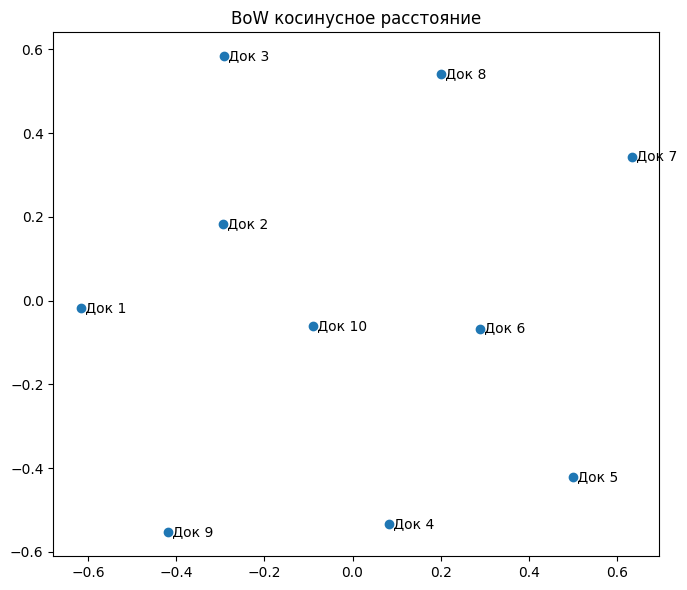

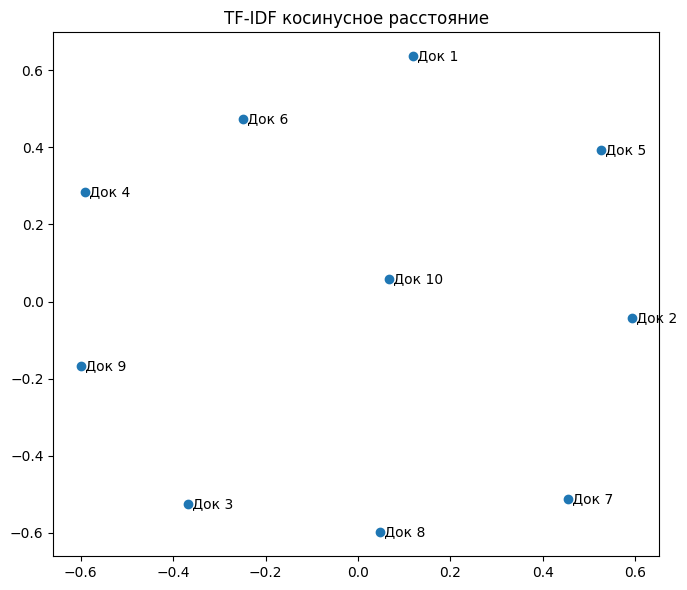

In [81]:
#Графики косинусное расстояние
docs_clean = [" ".join(preprocess_text(d)) for d in documents]
labels = [f"Док {i+1}" for i in range(len(docs_clean))]

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

bow = CountVectorizer()
X_bow = bow.fit_transform(docs_clean)

tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(docs_clean)
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_distances

def plot_mds(X, labels, title):
    D = cosine_distances(X)
    coords = MDS(n_components=2, dissimilarity="precomputed", random_state=42).fit_transform(D)

    plt.figure(figsize=(7,6))
    plt.scatter(coords[:,0], coords[:,1])
    for i, lab in enumerate(labels):
        plt.text(coords[i,0], coords[i,1], " " + lab, va="center")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_mds(X_bow, labels, "BoW косинусное расстояние")
plot_mds(X_tfidf, labels, "TF-IDF косинусное расстояние")


**Задание 2: Морфологическая разметка текста**

1. Возьмите отрывок текста (минимум 300 слов) на русском и английском языке.
2. Для русского языка используйте PyMorphy2 или PyMorphy3, для английского - NLTK или SpaCy для проведения морфологического анализа.
3. Выполните следующие операции:
* Определите части речи для каждого слова в тексте
* Для существительных определите падеж, род и число
* Для глаголов определите время, лицо и число
* Создайте частотный словарь частей речи в тексте
4. Разработайте функцию, которая будет автоматически изменять текст, заменяя все существительные на их форму множественного числа (где возможно).
5. Результаты морфологического анализа должны быть представлены в виде таблицы.
6. Оцените и прокомментируйте точность определения морфологических характеристик

In [9]:
!pip install pymorphy3

import nltk
import string
import re
import pymorphy3
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('universal_tagset')
nltk.download('averaged_perceptron_tagger_eng')

from nltk import FreqDist
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from pymorphy3 import MorphAnalyzer
from collections import Counter

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


In [10]:
russian_text = """Девушка отрывается от книги и смотрит в окно. Со второго этажа видна оживленная улица. Несмотря на позднее время, там довольно светло, и разные люди бродят в разные стороны. Одни куда-то идут, другие никуда особо не торопятся. У одних есть цель, у других цели нет. Одни умоляют время задержаться подольше – другие подталкивают его в спину, лишь бы оно бежало еще быстрей. Наглядевшись на уличный хаос, девушка вздыхает, погружается в книгу. Протягивает руку к чашке с кофе. Сигарета, которой она затянулась раза три, оседает в пепельнице ровным столбиком пепла.
Стеклянная дверь автоматически открывается, в ресторанчик входит высокий и тощий молодой человек. Черное пальто из кожи, мешковатые оливковые штаны, коричневые рабочие ботинки. Длинные волосы торчат в разные стороны. Возможно, он уже несколько дней не мыл голову. А может, только что выбрался из какого-нибудь подземелья. Не исключаем также, что ходить лохматым – его обычное состояние. Стройный, хотя и не красавчик – скорее из тех, кому говорят: «Вы плохо питаетесь». С плеча свисает большой черный футляр музыкального инструмента. Судя по всему, духового. В руке – замызганная
папка для бумаг. Очевидно, с нотами и прочей студенческой дребеденью. На правой щеке глубокий шрам. Короткий и рваный, будто щеку проткнули какой-то пикой. Больше, пожалуй, ничего примечательного. Обычный парень, каких тысячи. Похож на бродячего пса – покладистого, но сбившегося с пути, а потому немного безумного.
Официантка подводит его к свободному столику. Парень проходит мимо читающей девушки. Уже миновав ее, вдруг останавливается – и медленно возвращается, как на кинопленке, пущенной назад. Остановившись напротив девушки, склоняет голову набок и с интересом вглядывается в ее лицо. Пытается вспомнить, но сразу не может. Есть такая порода людей: за что ни возьмутся, сразу не получается ничего.
Уловив, что происходит, девушка поднимает голову и, прищурившись, поворачивается к нему. Росту парень немалого – она задирает голову. Их взгляды встречаются, и парень улыбается. Широко и дружелюбно."""

morph = MorphAnalyzer()
punctuation = string.punctuation
punctuation += '–-«»№'
translator = str.maketrans('', '', punctuation)
russian_text = russian_text.translate(translator)
tokens = word_tokenize(russian_text.lower())
list_rus_tagged = []

for token in tokens:
    parses = morph.parse(token)
    pos = parses[0].tag.POS
    _case = parses[0].tag.case
    gender = parses[0].tag.gender
    number = parses[0].tag.number
    person = parses[0].tag.person
    tense = parses[0].tag.tense
    if pos == 'NOUN':
        list_rus_tagged.append(f'{token}_{pos}_{_case}_{gender}_{number}')
    elif pos == 'VERB':
        list_rus_tagged.append(f'{token}_{pos}_{person}_{tense}_{number}')
    else:
        list_rus_tagged.append(f'{token}_{pos}')
print(f"Части речи: {list_rus_tagged}")

#частотный словарь частей речи в тексте
pos_tags = []
for tagged_token in list_rus_tagged:
    parts = tagged_token.split('_')
    pos_tag = parts[1]
    pos_tags.append(pos_tag)

freq = Counter(pos_tags)
print("Частотный словарь:", freq)


Части речи: ['девушка_NOUN_nomn_femn_sing', 'отрывается_VERB_3per_pres_sing', 'от_PREP', 'книги_NOUN_gent_femn_sing', 'и_CONJ', 'смотрит_VERB_3per_pres_sing', 'в_PREP', 'окно_NOUN_accs_neut_sing', 'со_PREP', 'второго_ADJF', 'этажа_NOUN_gent_masc_sing', 'видна_ADJS', 'оживленная_ADJF', 'улица_NOUN_nomn_femn_sing', 'несмотря_PREP', 'на_PREP', 'позднее_ADJF', 'время_NOUN_accs_neut_sing', 'там_ADVB', 'довольно_ADVB', 'светло_ADVB', 'и_CONJ', 'разные_ADJF', 'люди_NOUN_nomn_masc_plur', 'бродят_VERB_3per_pres_plur', 'в_PREP', 'разные_ADJF', 'стороны_NOUN_gent_femn_sing', 'одни_ADJF', 'кудато_NOUN_nomn_masc_sing', 'идут_VERB_3per_pres_plur', 'другие_ADJF', 'никуда_ADVB', 'особо_ADVB', 'не_PRCL', 'торопятся_VERB_3per_pres_plur', 'у_PREP', 'одних_ADJF', 'есть_INFN', 'цель_NOUN_nomn_femn_sing', 'у_PREP', 'других_ADJF', 'цели_NOUN_gent_femn_sing', 'нет_PRED', 'одни_ADJF', 'умоляют_VERB_3per_pres_plur', 'время_NOUN_accs_neut_sing', 'задержаться_INFN', 'подольше_COMP', 'другие_ADJF', 'подталкивают_V

In [11]:
#замена всех сущ в русском тексте на форму мн ч
def pluralize_nouns(text):
    # Удаляем знаки препинания
    translator = str.maketrans('', '', string.punctuation+'–-«»№')
    clean_text = text.translate(translator)

    # Токенизация текста
    tokens = word_tokenize(clean_text.lower())

    # Анализируем каждую лексему
    morph = MorphAnalyzer()
    result_tokens = []

    for token in tokens:
        parsed = morph.parse(token)[0]

        # Если токен является существительным единственного числа
        if parsed.tag.POS == 'NOUN' and parsed.tag.number == 'sing':
            try:
                plural_form = parsed.inflect({'plur'})
                if plural_form:
                    result_tokens.append(plural_form.word)
                else:
                    result_tokens.append(token)

            except Exception as e:
                print(f"Ошибка обработки '{token}': {e}")
                result_tokens.append(token)
        else:
            result_tokens.append(token)

    return ' '.join(result_tokens)

pluralized_rus_text = pluralize_nouns(russian_text)
print(pluralized_rus_text)

девушки отрывается от книг и смотрит в окна со второго этажей видна оживленная улицы несмотря на позднее времена там довольно светло и разные люди бродят в разные сторон одни кудато идут другие никуда особо не торопятся у одних есть цели у других целей нет одни умоляют времена задержаться подольше другие подталкивают его в спины лишь бы оно бежало еще быстрей наглядевшись на уличный хаосы девушки вздыхает погружается в книги протягивает руки к чашках с кофе сигареты которой она затянулась раз три оседает в пепельницам ровным столбиками пеплов стеклянная двери автоматически открывается в ресторанчики входит высокий и тощий молодой люди черное пальто из кож мешковатые оливковые штаны коричневые рабочие ботинки длинные волосы торчат в разные сторон возможно он уже несколько дней не мыл головы а может только что выбрался из какогонибудь подземелий не исключаем также что ходить лохматым его обычное состояния стройный хотя и не красавчики скорее из тех кому говорят вы плохо питаетесь с плеч 

In [12]:
english_text = """The man does not move. Every now and then he takes a long, deep breath and his shoulders slowly rise and fall. He could be a hostage who has been confined to a single room for a very long time. Hovering around him there seems to be a drawn-out sense of resignation. Not that he is tied to the chair: he just sits there with his back straight, breathing quietly, staring at one spot directly in front of him. We cannot tell by looking at him whether
he has decided for himself that he will not move or he has been placed into some kind of situation that does not permit him to move. His hands rest on his knees. The time is unclear. We cannot even tell if it is night or day. In the light of the banked fluorescent lamps, however, the room is as bright as a summer afternoon. Eventually the camera circles around to the front and shows his face, but this does not help us to identify him. The mystery only deepens. His entire
face is covered by a translucent mask. Perhaps we should not call it a mask: it clings so closely to his face, it is more like a piece of plastic wrap. But, thin as it is, it still serves its purpose as a mask. While reflecting the light that strikes it as a pale luster, it never fails to conceal the man’s features and expression. The best we can do is surmise the general contours of his face. The mask has no holes for the nose, mouth, or eyes, but still it does not seem to
prevent him from breathing or seeing or hearing. Perhaps it has outstanding breathability or permeability, but, viewing it from the outside, we cannot tell what kind of material or technology has been used to make it. The mask possesses equal levels of sorcery and functionality. It has been both handed down from ancient times with darkness and sent back from the future with light."""

punctuation = string.punctuation
punctuation += '–-«»№'
translator = str.maketrans('', '', punctuation)
english_text = english_text.translate(translator)
english_text = word_tokenize(english_text.lower())
tagged_eng = nltk.pos_tag(english_text)
list_eng_tagged = []
for elem in tagged_eng:
    tag_tog = '_'.join(elem)
    list_eng_tagged.append(tag_tog)
print(f"Части речи: {list_eng_tagged}")

#частотный словарь частей речи в тексте
tags = [tag for (_, tag) in tagged_eng]
freq = dict(Counter(tags))
print("Частотный словарь : ", freq)


Части речи: ['the_DT', 'man_NN', 'does_VBZ', 'not_RB', 'move_VB', 'every_DT', 'now_RB', 'and_CC', 'then_RB', 'he_PRP', 'takes_VBZ', 'a_DT', 'long_JJ', 'deep_JJ', 'breath_NN', 'and_CC', 'his_PRP$', 'shoulders_NNS', 'slowly_RB', 'rise_NN', 'and_CC', 'fall_NN', 'he_PRP', 'could_MD', 'be_VB', 'a_DT', 'hostage_NN', 'who_WP', 'has_VBZ', 'been_VBN', 'confined_VBN', 'to_TO', 'a_DT', 'single_JJ', 'room_NN', 'for_IN', 'a_DT', 'very_RB', 'long_JJ', 'time_NN', 'hovering_VBG', 'around_RB', 'him_PRP', 'there_RB', 'seems_VBZ', 'to_TO', 'be_VB', 'a_DT', 'drawnout_NN', 'sense_NN', 'of_IN', 'resignation_NN', 'not_RB', 'that_IN', 'he_PRP', 'is_VBZ', 'tied_VBN', 'to_TO', 'the_DT', 'chair_NN', 'he_PRP', 'just_RB', 'sits_VBZ', 'there_RB', 'with_IN', 'his_PRP$', 'back_NN', 'straight_VBD', 'breathing_VBG', 'quietly_RB', 'staring_VBG', 'at_IN', 'one_CD', 'spot_NN', 'directly_RB', 'in_IN', 'front_NN', 'of_IN', 'him_PRP', 'we_PRP', 'can_MD', 'not_RB', 'tell_VB', 'by_IN', 'looking_VBG', 'at_IN', 'him_PRP', 'wheth

Частеречная разметка английского текста nltk

NN	Noun, singular or mass

NNS	Noun, plural

NNP	Proper noun, singular

VB	Verb, base form

VBD	Verb, past tense

VBG	Verb, gerund/present participle

VBN	Verb, past participle

VBZ	Verb, 3rd person singular present

JJ	Adjective

RB	Adverb

DT	Determiner

IN	Preposition/subordinating conjunction

PRP	Personal pronoun

POS	Possessive ending	"'s"

CC	Coordinating conjunction

MD	Modal verb

TO	to (as preposition or infinitive marker)



In [13]:
#замена всех сущ в английском тексте на форму мн ч
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def pluralize_noun(word):
    lemmatizer = WordNetLemmatizer()
    lemma = lemmatizer.lemmatize(word, pos='n')  # Приводим слово к исходной форме
    if len(word) > 2 and word.endswith(('s', 'sh', 'ch')):
        return f"{word[:-1]}es"
    elif word[-1:] == 'y' and word[-2:-1] != 'a':
        return f"{word[:-1]}ies"
    else:
        return f"{lemma}s"

def convert_to_plural(text):
    words = word_tokenize(text.lower())
    pluralized_words = []

    for word, pos in nltk.pos_tag(words):
        if pos.startswith('NN'):  # Это существительное
            pluralized_words.append(pluralize_noun(word))
        else:
            pluralized_words.append(word)

    return ' '.join(pluralized_words)

pluralized_rus_text = pluralize_nouns(russian_text)
print(pluralized_rus_text)

девушки отрывается от книг и смотрит в окна со второго этажей видна оживленная улицы несмотря на позднее времена там довольно светло и разные люди бродят в разные сторон одни кудато идут другие никуда особо не торопятся у одних есть цели у других целей нет одни умоляют времена задержаться подольше другие подталкивают его в спины лишь бы оно бежало еще быстрей наглядевшись на уличный хаосы девушки вздыхает погружается в книги протягивает руки к чашках с кофе сигареты которой она затянулась раз три оседает в пепельницам ровным столбиками пеплов стеклянная двери автоматически открывается в ресторанчики входит высокий и тощий молодой люди черное пальто из кож мешковатые оливковые штаны коричневые рабочие ботинки длинные волосы торчат в разные сторон возможно он уже несколько дней не мыл головы а может только что выбрался из какогонибудь подземелий не исключаем также что ходить лохматым его обычное состояния стройный хотя и не красавчики скорее из тех кому говорят вы плохо питаетесь с плеч 

In [15]:
#Таблица сравнения результатов

import pandas as pd
from collections import Counter

# Приведение POS к общему уровню для сравнения
rus_pos_list = {
    'NOUN': 'NOUN', 'VERB': 'VERB', 'INFN': 'VERB', 'ADJF': 'ADJ', 'ADJS': 'ADJ', 'COMP': 'ADJ',
    'ADV': 'ADV', 'PRCL': 'PART', 'INTJ': 'INTJ', 'PREP': 'ADP', 'CONJ': 'CONJ', 'NPRO': 'PRON',
    'NUMR': 'NUM', 'PRED': 'OTHER', None: 'OTHER',
    'GRND': 'VERB',
    'PRTF': 'ADJ',
    'ADVB': 'ADV'
}
eng_pos_list = {
    'NN': 'NOUN', 'NNS': 'NOUN', 'NNP': 'NOUN', 'NNPS': 'NOUN',
    'VB': 'VERB', 'VBD': 'VERB', 'VBG': 'VERB', 'VBN': 'VERB', 'VBP': 'VERB', 'VBZ': 'VERB', 'MD': 'VERB',
    'JJ': 'ADJ', 'JJR': 'ADJ', 'JJS': 'ADJ',
    'RB': 'ADV', 'RBR': 'ADV', 'RBS': 'ADV', 'WRB': 'ADV', 'RP': 'ADV',
    'PRP': 'PRON', 'PRP$': 'PRON', 'WP': 'PRON', 'WP$': 'PRON',
    'IN': 'ADP', 'TO': 'ADP',
    'DT': 'DET', 'PDT': 'DET',
    'CC': 'CONJ',
    'CD': 'NUM',
    'UH': 'INTJ',
    '.': 'PUNCT', ',': 'PUNCT', ':': 'PUNCT', '(': 'PUNCT', ')': 'PUNCT', "''": 'PUNCT', '``': 'PUNCT',
    'FW': 'OTHER', 'EX': 'OTHER', 'LS': 'OTHER', 'SYM': 'OTHER',
    'POS': 'PART'
}


normalized_russian_pos_freq = Counter()
for pos_tag in rus_pos_list:
    normalized_russian_pos_freq[rus_map.get(pos_tag, 'OTHER')] += 1

normalized_english_pos_freq = Counter()
for pos_tag in eng_pos_list:
    normalized_english_pos_freq[eng_map.get(pos_tag, 'OTHER')] += 1

df_rus = pd.DataFrame.from_dict(normalized_russian_pos_freq, orient='index', columns=['Русский текст'])
df_eng = pd.DataFrame.from_dict(normalized_english_pos_freq, orient='index', columns=['Английский текст'])

df_morph_comparison = pd.concat([df_rus, df_eng], axis=1).fillna(0).astype(int)

df_morph_comparison['Total Count'] = df_morph_comparison['Русский текст'] + df_morph_comparison['Английский текст']
df_morph_comparison = df_morph_comparison.sort_values(by='Total Count', ascending=False).drop(columns='Total Count')

print("Таблица сравнения частот частей речи:")
from IPython.display import display
display(df_morph_comparison)

Таблица сравнения частот частей речи:


,Русский текст,Английский текст
VERB,3,7
ADV,2,5
ADJ,4,3
PUNCT,0,7
OTHER,2,4
PRON,1,4
NOUN,1,4
ADP,1,2
PART,1,1
CONJ,1,1


**Задание 3: Синтаксический анализ предложений**

1. Возьмите 2 простых и 3 сложных предложений на русском и английском языке (всего 10 предложений).
2. Используйте SpaCy для построения синтаксических деревьев этих предложений.
3. Для каждого предложения:
* Визуализируйте синтаксическое дерево
* Выделите все подлежащие и сказуемые
* Найдите все пары слов, связанные отношением определения (прилагательное-существительное)
4. Разработайте функцию для извлечения всех объектных и субъектных отношений из предложения в формате (субъект, предикат, объект).
5. Объясните, какие трудности возникают при синтаксическом анализе сложных предложений

In [16]:
!python -m spacy download ru_core_news_sm  # Русский язык (малая модель)
!python -m spacy download en_core_web_sm   # Английский язык (малая модель)
# Опционально для более точного анализа:
!python -m spacy download ru_core_news_md  # Русский язык (средняя модель)
!python -m spacy download en_core_web_md   # Английский язык (средняя модель)
import spacy
# Загрузка языковых моделей
nlp_ru = spacy.load("ru_core_news_sm")
nlp_en = spacy.load("en_core_web_sm")
!pip install -U spacy
from spacy import displacy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 80.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 101.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 MB 5.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('r

In [17]:
# ваш код
russian_sentences = [
    "Солнце светит ярко.",
    "Дети играют в маленьком парке.",
    "Я знаю странного человека уже более 10 лет, он очень боится лабубу.",
    "Когда я вышел из дома, начался сильный дождь, из-за этого я пропустил пары.",
    "В полицию позвонила взволнованная женщина и рассказала, что на крыше многоэтажки находится подросток, он громко кричит что-то несвязное."
]

english_sentences = [
    "The cat sleeps on the sofa.",
    "She reads inspiring books.",
    "A man stabbed his defenceless wife to death and his daughter called emergency services.",
    "The sun is shining brightly although some dark clouds are gathering in the distance.",
    "She reaches for the bill on the table, but the tall woman beats her to it."
]


In [18]:
#Синтаксические деревья предложений рус
docs_ru = [nlp_ru(text) for text in russian_sentences]
displacy.render(docs_ru, style='dep', options={'compact': False})

In [19]:
##Синтаксические деревья предложений англ
docs_en = [nlp_en(text) for text in english_sentences]
displacy.render(docs_en, style='dep', options={'compact': True})

In [20]:
# Извлечение подлежащего и сказуемого для русского
from spacy.symbols import nsubj, VERB, amod, NOUN, dobj, obl

def find_subj_and_pred(doc):
  pairs = []
  for word in doc:
    if word.dep == nsubj and word.head.pos == VERB:
      pairs.append([word, word.head])
  return pairs

print("Подлежащее и сказуемое русский язык:\n")
for doc in docs_ru:
  print(f"Предложение: {doc}")
  display(find_subj_and_pred(doc))
  print()

Подлежащее и сказуемое русский язык:

Предложение: Солнце светит ярко.


[[Солнце, светит]]


Предложение: Дети играют в маленьком парке.


[[Дети, играют]]


Предложение: Я знаю странного человека уже более 10 лет, он очень боится лабубу.


[[Я, знаю], [он, боится]]


Предложение: Когда я вышел из дома, начался сильный дождь, из-за этого я пропустил пары.


[[я, вышел], [дождь, начался], [я, пропустил]]


Предложение: В полицию позвонила взволнованная женщина и рассказала, что на крыше многоэтажки находится подросток, он громко кричит что-то несвязное.


[[женщина, позвонила], [подросток, находится], [он, кричит]]

In [21]:
# Извлечение подлежащего и сказуемого для английского
print("Подлежащее и сказуемое английский язык:\n")
for doc in docs_en:
  print(f"Предложение: {doc}")
  display(find_subj_and_pred(doc))
  print()

Подлежащее и сказуемое английский язык:

Предложение: The cat sleeps on the sofa.


[[cat, sleeps]]


Предложение: She reads inspiring books.


[[She, reads]]


Предложение: A man stabbed his defenceless wife to death and his daughter called emergency services.


[[man, stabbed], [daughter, called]]


Предложение: The sun is shining brightly although some dark clouds are gathering in the distance.


[[sun, shining], [clouds, gathering]]


Предложение: She reaches for the bill on the table, but the tall woman beats her to it.


[[She, reaches], [woman, beats]]

In [22]:
#пары слов, связанные отношением определения (прилагательное-существительное) rus
def adj_noun_pairs(doc):
  pairs = []
  for word in doc:
    if word.dep == amod and word.head.pos == NOUN:
      pairs.append([word, word.head])
  return pairs

print("Прилагательное-существительное русский язык:\n")
for doc in docs_ru:
  print(f"Предложение: {doc}")
  display(adj_noun_pairs(doc))
  print()

Прилагательное-существительное русский язык:

Предложение: Солнце светит ярко.


[]


Предложение: Дети играют в маленьком парке.


[[маленьком, парке]]


Предложение: Я знаю странного человека уже более 10 лет, он очень боится лабубу.


[[странного, человека]]


Предложение: Когда я вышел из дома, начался сильный дождь, из-за этого я пропустил пары.


[[сильный, дождь]]


Предложение: В полицию позвонила взволнованная женщина и рассказала, что на крыше многоэтажки находится подросток, он громко кричит что-то несвязное.


[[взволнованная, женщина]]

In [85]:
#пары слов, связанные отношением определения (прилагательное-существительное) eng
print("Прилагательное-существительное английский язык:\n")
for doc in docs_en:
  print(f"Предложение: {doc}")
  display(adj_noun_pairs(doc))
  print()

Прилагательное-существительное английский язык:

Предложение: The cat sleeps on the sofa.


[]


Предложение: She reads inspiring books.


[[inspiring, books]]


Предложение: A man stabbed his defenceless wife to death and his daughter called emergency services.


[[defenceless, wife]]


Предложение: The sun is shining brightly although some dark clouds are gathering in the distance.


[[dark, clouds]]


Предложение: She reaches for the bill on the table, but the tall woman beats her to it.


[[tall, woman]]

In [86]:
# Функция для извлечения всех объектных и субъектных отношений из предложения в формате (субъект, предикат, объект) ru
def extract_svo(doc):
    triples = []
    for token in doc:
        # Определяем подлежащее (субъект)
        if token.dep_ == "nsubj" or token.dep_ == "nsubj:pass":  # Возможны также случаи пассивного залога
            subject = token.text
            verb = token.head.text
            obj_list = []
            # Поиск прямого дополнения (объекта)
            for child in token.head.children:
                if child.dep_ == "dobj" or child.dep_ == "obl":
                    obj_list.append(child.text)

            if len(obj_list) > 0:
                triples.append([subject, verb, ", ".join(obj_list)])

    return triples

# Обрабатываем каждый пример предложения
print("Субъект-предикат-объект русский язык:\n")
for doc in docs_ru:
    extracted_triples = extract_svo(doc)
    print(f"Предложение: {doc}")
    if extracted_triples:
        for t in extracted_triples:
            print(t)
    else:
        print("[]")
    print()

Субъект-предикат-объект русский язык:

Предложение: Солнце светит ярко.
[]

Предложение: Дети играют в маленьком парке.
['Дети', 'играют', 'парке']

Предложение: Я знаю странного человека уже более 10 лет, он очень боится лабубу.
['Я', 'знаю', 'лет']

Предложение: Когда я вышел из дома, начался сильный дождь, из-за этого я пропустил пары.
['я', 'вышел', 'дома']
['я', 'пропустил', 'этого']

Предложение: В полицию позвонила взволнованная женщина и рассказала, что на крыше многоэтажки находится подросток, он громко кричит что-то несвязное.
['женщина', 'позвонила', 'полицию']
['подросток', 'находится', 'крыше']



In [87]:
print("Субъект-предикат-объект английский язык:\n")
for doc in docs_en:
    extracted_triples = extract_svo(doc)
    print(f"Предложение: {doc}")
    if extracted_triples:
        for t in extracted_triples:
            print(t)
    else:
        print("[]")
    print()

Субъект-предикат-объект английский язык:

Предложение: The cat sleeps on the sofa.
[]

Предложение: She reads inspiring books.
['She', 'reads', 'books']

Предложение: A man stabbed his defenceless wife to death and his daughter called emergency services.
['man', 'stabbed', 'wife']

Предложение: The sun is shining brightly although some dark clouds are gathering in the distance.
[]

Предложение: She reaches for the bill on the table, but the tall woman beats her to it.
['woman', 'beats', 'her']



**Задание 4: Распознавание именованных сущностей (Named Entity Recognition)**

1. Подготовьте корпус из 10 новостных текстов, содержащий различные типы именованных сущностей (имена людей, организации, географические названия, даты и т.д.) на английском или русском языке.
2. Используйте SpaCy для автоматического распознавания именованных сущностей.
3. Реализуйте свой простой метод для распознавания имен людей и географических названий с помощью регулярных выражений и словарей.
4. Сравните результаты работы SpaCy и вашего метода:
* Рассчитайте точность (precision), полноту (recall) и F1-меру для вашего метода относительно результатов SpaCy
* Проанализируйте ошибки обоих подходов, какие типы ошибок характерны для каждого подхода
5. Представьте сравнение результатов в виде таблицы

In [26]:
# Импортируем необходимые библиотеки
import matplotlib.pyplot as plt
import re
import string
from collections import Counter, defaultdict
from sklearn.metrics import precision_recall_fscore_support, classification_report
import spacy

# Загрузим необходимые ресурсы из NLTK
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('maxent_ne_chunker_tab')
nltk.download('words')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker_tab to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker_tab.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [27]:
try:
    nlp_ru = spacy.load("ru_core_news_sm")
    spacy_available = True
except Exception:
    nlp_ru = None
    spacy_available = False

In [28]:
# ваш код
russian_ner_texts = [
    """Президент России Владимир Путин в ходе визита в Казахстан провёл переговоры с главой республики Касым-Жомартом Токаевым.
    Основные дискуссии были посвящены развитию торгово-экономического сотрудничества в рамках ЕЭС.""",
    """Европейское космическое агентство и «Роскосмос» договорились о продлении совместной работы на
    Международной космической станции как минимум до 2030 года. Соответствующее заявление было сделано в Париже.""",
    """С 1 февраля 2026 г. все товары, поставляемые в США из Дании, Норвегии, Швеции, Франции, Германии, Великобритании,
    Нидерландов и Финляндии, будут облагаться пошлиной в размере 10%. Об этом объявил американский президент Дональд Трамп в Truth Social.""",
    """На юго-востоке Украины, в Донецкой области, 18 марта произошёл сильный обстрел, в результате которого пострадали гражданские объекты.
    Представитель ООН по гуманитарным вопросам Марк Хьюз призвал к немедленному прекращению огня и обеспечению доступа для гуманитарной помощи.""",
    """Компания «Яндекс» подписала соглашение с Университетом Санкт-Петербурга 05.02.2026 о создании исследовательского центра по квантовым вычислениям.
    Главный исполнительный директор Аркадий Волков и ректор Елена Смирнова присутствовали на церемонии в Петрозаводске.""",
    """В Министерстве здравоохранения России объявили о запуске национальной вакцинационной кампании против сезонного гриппа.
    Министр Вероника Иванова провела брифинг в Москве. Программа финансируется из федерального бюджета на сумму 5 млрд рублей.""",
    """В Санкт-Петербурге 20 июня откроется выставка современного искусства «Новые горизонты» в музее Эрмитаж. Художник Марк Резников
    представит серию работ, созданных в сотрудничестве с Берлинской галереей Kunsthalle. Стоимость билетов составит 600 рублей.""",
    """Розничная сеть «МегаМаркет» объявила о старте распродажи 1 сентября. Генеральный директор Павел Новиков сообщил о скидках до 70%
    в филиалах в Екатеринбурге, Новосибирске и Казани. Акция продлится до 10 сентября.""",
    """Власти Новосибирской области объявили о запуске инфраструктурного проекта по строительству моста через реку Обь. Строительство начнётся 01.09.2026.
    Губернатор Анна Сергеева заявила, что проект финансируется совместно с банком ВТБ и предполагает инвестирование в размере 12 млрд рублей.""",
    """Американский производитель электромобилей Tesla с середины следующего месяца перестанет продавать систему автопилота FSD, сделав его доступным
    по ежемесячной подписке, сообщил глава компании Илон Маск. На данный момент разовая покупка FSD стоит восемь тысяч долларов, а стоимость ежемесячной подписки
    составляет 99 долларов.  """
]


In [29]:
#  SpaCy для автоматического распознавания именованных сущностей
def spacy_ner(text, language='russian'):
    """
    Распознавание именованных сущностей с помощью spaCy
    Принимает одну строку, возвращает список кортежей (текст, метка)
    """
    if not spacy_available or nlp_ru is None:
        return []
    doc = nlp_ru(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return entities

if spacy_available:
    print("\nИменованные сущности (spaCy)")
    print('-' * 50)

    # Объединяем все сущности из всех текстов в один общий список
    russian_entities_spacy = []
    for txt in russian_ner_texts:
        russian_entities_spacy.extend(spacy_ner(txt))

    # Просто выводим все сущности подряд
    for ent_text, ent_label in russian_entities_spacy:
        print(f"- {ent_text} {ent_label}")


Именованные сущности (spaCy)
--------------------------------------------------
- России LOC
- Владимир Путин PER
- Казахстан LOC
- Касым-Жомартом LOC
- Европейское космическое агентство ORG
- Роскосмос ORG
- Международной космической станции ORG
- Париже LOC
- США LOC
- Дании LOC
- Норвегии LOC
- Швеции LOC
- Франции LOC
- Германии LOC
- Великобритании LOC
- Нидерландов LOC
- Финляндии LOC
- Дональд Трамп PER
- Truth Social ORG
- Украины LOC
- Донецкой области LOC
- ООН ORG
- Марк Хьюз PER
- Яндекс ORG
- Университетом Санкт-Петербурга ORG
- Аркадий Волков PER
- Елена Смирнова PER
- Петрозаводске LOC
- Министерстве здравоохранения ORG
- России LOC
- Вероника Иванова PER
- Москве LOC
- Санкт-Петербурге LOC
- Новые горизонты ORG
- Эрмитаж ORG
- Марк Резников PER
- Берлинской галереей ORG
- Kunsthalle ORG
- МегаМаркет ORG
- Павел Новиков PER
- Екатеринбурге LOC
- Новосибирске LOC
- Казани LOC
- Новосибирской области LOC
- Обь LOC
- Анна Сергеева PER
- ВТБ ORG
- Tesla ORG
- FSD ORG
- Илон

In [30]:
#Cвой простой метод для распознавания имен людей и географических названий с помощью регулярных выражений и словарей
def improved_rule_based_ner(text):

    entities = []

    # Словари для разных типов сущностей
    person_prefixes = { 'Президент', 'Г-н', 'Г-жа', 'Доктор', 'Профессор', 'Господин', 'Госпожа', 'Товарищ', 'Студент', 'Студентка', 'Спортсмен',
                       'Министр', 'Король', 'Королева', 'Глава', 'Руководитель', 'Директор', 'Генеральный', 'Исполнительный', 'Главный',
                        'Ректор', 'Губернатор', 'Представитель', 'Художник', 'Генеральный директор', 'Главный исполнительный директор',}

    location_prefixes = {'в', 'из', 'на', 'от', 'до', 'через', 'по', 'у', 'около', 'возле', 'под', 'над', 'с', 'со', 'вокруг', 'внутри', 'за', 'перед', 'между', 'среди',}

    organizations = {'Apple', 'Google', 'Microsoft', 'IBM', 'Facebook', 'Twitter', 'NASA', 'FBI', 'CIA', 'NATO', 'WWF', 'Wildberries', 'Ozon',
                     'Amazon', 'EU', 'Instagram', 'Pinterest', 'Tesla', 'Truth Social', 'Kunsthalle', 'ЕЭС', 'FSD',   'ООН', 'Газпром', 'Сбербанк', 'Яндекс', 'Роснефть', 'МГУ',
                     'РЖД', 'ФСБ', 'ДВФУ', 'МТС', 'Магнит', 'Т-Банк', 'Вайлдберриз', 'Вайлдберрис', 'Озон', 'Роскосмос', 'ВТБ', 'МегаМаркет', 'Эрмитаж',
                      'Министерство здравоохранения', 'Министерство', 'Университет Санкт-Петербурга', 'Берлинская галерея', 'Европейское космическое агентство'
                       'Международная космическая станция', 'МКС'}

    devices = {'iPhone', 'iPad', 'PlayStation', 'AirPods', 'Айфон', 'Айпад', 'FSD'}

    date_patterns = [
        r'\d{1,2}\s(?:January|February|March|April|May|June|July|August|September|October|November|December)\s\d{4}',
        r'\d{1,2}\s(?:января|февраля|марта|апреля|мая|июня|июля|августа|сентября|октября|ноября|декабря)\s\d{4}',
        r'\d{1,2}/\d{1,2}/\d{4}',
        r'\d{1,2}\.\d{1,2}\.\d{4}'
    ]

    money_patterns = [
        r'($\d+)(?:((,\d+)*(\.\d+)))?',
        r'(((\d{1,3}(?: \d{3})+)\s)|(\d+(?:,\d+)*(?:\.\d+)?\s))'
        r'(?:(млн |млрд |тыс \.\s)?(USD|EUR|GBP|RUB|руб\.|долларов|евро|рублей))',
    ]



    # Токенизация текста
    words = word_tokenize(text, language='russian')

    # Поиск дат
    for pattern in date_patterns:
        for match in re.finditer(pattern, text):
            entities.append((match.group(), 'DATE'))

    # Поиск денежных сумм
    for pattern in money_patterns:
        for match in re.finditer(pattern, text):
            entities.append((match.group(), 'MONEY'))

    # Поиск людей, мест и организаций
    i = 0

    while i < len(words):
        # Поиск людей
        if i < len(words) - 1 and words[i] in person_prefixes:
            # Если слово после префикса начинается с заглавной буквы
            if words[i+1][0].isupper():
                # Собираем полное имя
                name_parts = []
                j = i + 1
                while j < len(words) and words[j][0].isupper() and words[j] not in string.punctuation:
                    name_parts.append(words[j])
                    j += 1
                if name_parts:
                    entities.append((' '.join([words[i]] + name_parts), 'PERSON'))
                    i = j
                    continue
        # Поиск организаций
        if words[i] in organizations:
            entities.append((words[i], 'ORGANIZATION'))

        # Поиск мест
        if i < len(words) - 1 and words[i] in location_prefixes:
            if words[i+1][0].isupper():
                entities.append((words[i+1], 'LOCATION'))

         # Поиск устройств
        if words[i] in devices:
            entities.append((words[i], 'DEVICE'))


        i += 1

    return entities

russian_entities_rule = []
for txt in russian_ner_texts:
    russian_entities_rule.extend(improved_rule_based_ner(txt))

print("\nРеализация NER на основе правил")
print('-' * 50)
for entity, entity_type in russian_entities_rule:
    print(f"- {entity}: {entity_type}")



Реализация NER на основе правил
--------------------------------------------------
- Президент России Владимир Путин: PERSON
- Казахстан: LOCATION
- ЕЭС: ORGANIZATION
- Роскосмос: ORGANIZATION
- Международной: LOCATION
- Париже: LOCATION
- 1 февраля 2026: DATE
- США: LOCATION
- Дании: LOCATION
- Truth: LOCATION
- Донецкой: LOCATION
- Представитель ООН: PERSON
- 05.02.2026: DATE
- Яндекс: ORGANIZATION
- Университетом: LOCATION
- Петрозаводске: LOCATION
- 5 млрд рублей: MONEY
- Министр Вероника Иванова: PERSON
- Москве: LOCATION
- 600 рублей: MONEY
- Эрмитаж: ORGANIZATION
- Художник Марк Резников: PERSON
- Берлинской: LOCATION
- Kunsthalle: ORGANIZATION
- МегаМаркет: ORGANIZATION
- Екатеринбурге: LOCATION
- 01.09.2026: DATE
- 12 млрд рублей: MONEY
- Губернатор Анна Сергеева: PERSON
- ВТБ: ORGANIZATION
- 99 долларов: MONEY
- Tesla: ORGANIZATION
- FSD: ORGANIZATION
- FSD: DEVICE
- FSD: ORGANIZATION
- FSD: DEVICE


In [31]:
#Рассчитайте точность (precision), полноту (recall) и F1-меру для вашего метода относительно результатов SpaCy

# "Золотой стандарт" для русского текста
russian_gold_standard = [
        ('Президент России', 'TITLE'),
        ('Владимир Путин', 'PERSON'),
        ('России', 'LOCATION'),
        ('Казахстан', 'LOCATION'),
        ('глава республики', 'TITLE'),
        ('Касым-Жомартом Токаевым', 'PERSON'),
        ('республики', 'ORGANIZATION'),
        ('ЕЭС', 'ORGANIZATION'),
        ('Европейское космическое агентство', 'ORGANIZATION'),
        ('Роскосмос', 'ORGANIZATION'),
        ('Международной космической станции', 'ORGANIZATION'),
        ('до 2030 года', 'DATE'),
        ('2030 года', 'DATE'),
        ('Париже', 'LOCATION'),
        ('С 1 февраля 2026 г.', 'DATE'),
        ('1 февраля 2026 г.', 'DATE'),
        ('США', 'LOCATION'),
        ('Дании', 'LOCATION'),
        ('Норвегии', 'LOCATION'),
        ('Швеции', 'LOCATION'),
        ('Франции', 'LOCATION'),
        ('Германии', 'LOCATION'),
        ('Великобритании', 'LOCATION'),
        ('Нидерландов', 'LOCATION'),
        ('Финляндии', 'LOCATION'),
        ('10%', 'PERCENT'),
        ('американский президент', 'TITLE'),
        ('Дональд Трамп', 'PERSON'),
        ('Truth Social', 'ORGANIZATION'),
        ('юго-востоке Украины', 'LOCATION'),
        ('Украины', 'LOCATION'),
        ('Донецкой области', 'LOCATION'),
        ('18 марта', 'DATE'),
        ('ООН', 'ORGANIZATION'),
        ('Представитель ООН по гуманитарным вопросам', 'TITLE'),
        ('Марк Хьюз', 'PERSON'),
        ('Компания «Яндекс»', 'ORGANIZATION'),
        ('Яндекс', 'ORGANIZATION'),
        ('Университетом Санкт-Петербурга', 'ORGANIZATION'),
        ('05.02.2026', 'DATE'),
        ('Главный исполнительный директор', 'TITLE'),
        ('Аркадий Волков', 'PERSON'),
        ('ректор', 'TITLE'),
        ('Елена Смирнова', 'PERSON'),
        ('Петрозаводске', 'LOCATION'),
        ('Министерстве здравоохранения России', 'ORGANIZATION'),
        ('России', 'LOCATION'),
        ('сезонного гриппа', 'CONDITION'),
        ('Министр', 'TITLE'),
        ('Вероника Иванова', 'PERSON'),
        ('Москве', 'LOCATION'),
        ('федерального бюджета', 'ORGANIZATION'),
        ('5 млрд рублей', 'MONEY'),
        ('Санкт-Петербурге', 'LOCATION'),
        ('20 июня', 'DATE'),
        ('выставка современного искусства «Новые горизонты»', 'EVENT'),
        ('музее Эрмитаж', 'ORGANIZATION'),
        ('Эрмитаж', 'ORGANIZATION'),
        ('Художник', 'TITLE'),
        ('Марк Резников', 'PERSON'),
        ('Берлинской галереей Kunsthalle', 'ORGANIZATION'),
        ('Kunsthalle', 'ORGANIZATION'),
        ('600 рублей', 'MONEY'),
        ('Розничная сеть «МегаМаркет»', 'ORGANIZATION'),
        ('МегаМаркет', 'ORGANIZATION'),
        ('1 сентября', 'DATE'),
        ('Генеральный директор', 'TITLE'),
        ('Павел Новиков', 'PERSON'),
        ('Екатеринбурге', 'LOCATION'),
        ('Новосибирске', 'LOCATION'),
        ('Казани', 'LOCATION'),
        ('до 10 сентября', 'DATE'),
        ('10 сентября', 'DATE'),
        ('Новосибирской области', 'LOCATION'),
        ('инфраструктурного проекта', 'PROJECT'),
        ('моста через реку Обь', 'PROJECT'),
        ('реку Обь', 'LOCATION'),
        ('Обь', 'LOCATION'),
        ('01.09.2026', 'DATE'),
        ('Губернатор', 'TITLE'),
        ('Анна Сергеева', 'PERSON'),
        ('банком ВТБ', 'ORGANIZATION'),
        ('ВТБ', 'ORGANIZATION'),
        ('12 млрд рублей', 'MONEY'),
        ('Американский производитель электромобилей Tesla', 'ORGANIZATION'),
        ('Tesla', 'ORGANIZATION'),
        ('с середины следующего месяца', 'DATE'),
        ('систему автопилота FSD', 'PRODUCT'),
        ('FSD', 'PRODUCT'),
        ('глава компании', 'TITLE'),
        ('Илон Маск', 'PERSON'),
        ('восемь тысяч долларов', 'MONEY'),
        ('8 тысяч долларов', 'MONEY'),
        ('99 долларов', 'MONEY')
    ]

In [32]:
def evaluate_ner(predicted, gold_standard):
    """
    Оценка качества NER с помощью F-меры

    Аргументы:
        predicted: список кортежей (текст, тип) - предсказания модели
        gold_standard: список кортежей (текст, тип) - золотой стандарт

    Возвращает:
        precision, recall, f1: точность, полнота, F1-мера
    """
    # Преобразуем списки в множества для удобства сравнения
    predicted_set = set(predicted)
    gold_set = set(gold_standard)

    # Рассчитываем истинно положительные, ложно положительные и ложно отрицательные
    true_positives = len(predicted_set.intersection(gold_set))
    false_positives = len(predicted_set - gold_set)
    false_negatives = len(gold_set - predicted_set)

    # Рассчитываем точность, полноту и F1-меру
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1

# Функция для вывода результатов оценки
def print_evaluation_results(method_name, language, precision, recall, f1):
    print(f"\nРезультаты для {method_name} ({language}):")
    print('-' * 50)
    print(f"Точность (Precision): {precision:.4f}")
    print(f"Полнота (Recall): {recall:.4f}")
    print(f"F1-мера: {f1:.4f}")

In [33]:
# Оценка правилового подхода
ru_rule_precision, ru_rule_recall, ru_rule_f1 = evaluate_ner(russian_entities_rule, russian_gold_standard)
print_evaluation_results("Правиловой подход", "русский", ru_rule_precision, ru_rule_recall, ru_rule_f1)


Результаты для Правиловой подход (русский):
--------------------------------------------------
Точность (Precision): 0.6176
Полнота (Recall): 0.2258
F1-мера: 0.3307


In [34]:
#Для SpaCy не работает, так как отличаются лейблы. Адаптируем.

# Карта соответствия меток
label_mapping = {
    'PERSON': 'PER',
    'LOCATION': 'LOC',
    'ORGANIZATION': 'ORG',
    'DATE': 'DATE',
    'TITLE': 'TITLE'  # Может отсутствовать в spaCy
}

# Адаптированный золотой стандарт
russian_gold_standard_adapted = []
for text, label in russian_gold_standard:
    if label in label_mapping:
        russian_gold_standard_adapted.append((text, label_mapping[label]))
    else:
        russian_gold_standard_adapted.append((text, label))


# Оцениваем с адаптированным золотым стандартом
ru_spacy_precision_adapted, ru_spacy_recall_adapted, ru_spacy_f1_adapted = evaluate_ner(
    russian_entities_spacy, russian_gold_standard_adapted)


print("\nРезультаты для spaCy NER (русский):")
print('-' * 50)
print(f"Точность: {ru_spacy_precision_adapted:.4f}")
print(f"Полнота: {ru_spacy_recall_adapted:.4f}")
print(f"F1-мера: {ru_spacy_f1_adapted:.4f}")



Результаты для spaCy NER (русский):
--------------------------------------------------
Точность: 0.8980
Полнота: 0.4731
F1-мера: 0.6197


In [37]:
#Таблица сравнения результатов
import pandas as pd

data = {
    'Метод': ['Точность', 'Полнота', 'F1-мера'],
    'spaCy NER': [ru_spacy_precision_adapted, ru_spacy_recall_adapted, ru_spacy_f1_adapted],
    'Правиловый подход': [ru_rule_precision, ru_rule_recall, ru_rule_f1]
}

df_comparison = pd.DataFrame(data)


table = df_comparison.style \
    .hide(axis="index") \
    .format("{:.4f}", subset=['spaCy NER', 'Правиловый подход'])

print("Таблица сравнения результатов NER:")
display(table)

Таблица сравнения результатов NER:


Метод,spaCy NER,Правиловый подход
Точность,0.8980,0.6176
Полнота,0.4731,0.2258
F1-мера,0.6197,0.3307
